# Grouping in SMLM

In the analysis of SMLM data, especially cryoSMLM data the grouping of localizations from frame to frame that belong to the same _molecular event_ is important. For instance, a single molecule may stay bright for multiple frames or, more frequently (and perniciously), will blink intermittently (sometimes termed _photoblinking_ as it is reversibly dark in contrast to _photobleaching_ which is irreversibly dark).

While many algorithms have been developed to flag molecules for grouping and then for aggregating the individual localizations into a single _grouped_ localization, none of the aggregation algorithms accurately estimate the precision of the new group.

> Each individual localization represents an observation of the position of a single molecule at a specific time and a specific location of the excitation light sheet and detection focal plane. However, individual fluorescent molecules may persist through successive raw image frames at successive focal plane $z$ locations or through successive 3D raw image stacks before they photobleach. If multiple observations arise from a single molecule, they should not be treated as independent samples of the underlying photon distribution. Rather they should be combined into a higher precision estimate of the molecular position, which in turn represents a single sampling of the underlying distribution (e.g. for considerations of Nyquist sampling). Indeed, failure to account for multiple localizations of the same molecule can cause significant overestimation of the Nyquist limited resolution[$^6$](). To determine whether multiple localizations arose from the same molecule, we adopted a linking procedure similar to that outlined previously[$^{50}$](http://science.sciencemag.org/content/313/5793/1642). Specifically, if localizations were recorded across multiple consecutive 3D image stacks within 100 nm radius of the original position estimate, then these localizations were deemed to have arisen from the same molecule. 
>
> _Legant 2015_

The aim here is to develop and compare our method to previous methods of aggregation and to demonstrate that our new method estimates not only the mean but also distrbution of boot strapping estimates.

In this case bootstrapping means looking at the spread in small groups of grouped molecules. For instance if we have a thousand grouped localizations we can estimate the experimental spread by looking at the spread in groups of these grouped localizations. We can do this by sampling either with or without replacement.


https://coolors.co/ff8360-9d8df1-e8e288-7dce82-1cfeba

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.stats import chi2

# Generating Data

https://en.wikipedia.org/wiki/Variance#Distribution_of_the_sample_variance


In [3]:
def generate_data(*, num_localizations=1000000, groupsize=1000, grouping="uniform",
                  distribution="normal", coords="xyz", df=None):
    """generate data"""
    sigmas = ["sigma_" + c for c in coords]
    coords = [c + "0" for c in coords]

    columns = coords + sigmas
    if distribution.lower() == "uniform":
        # uniformly distributed data (space)
        data = (np.random.rand(num_localizations, len(columns)) - 0.5) * np.sqrt(12)
    elif distribution.lower() == "normal":
        # normally distributed data (space)
        data = np.random.randn(num_localizations, len(columns))
    else:
        raise TypeError("distribution type {} not recognized".format(distribution)) 
    
    data = pd.DataFrame(data, columns=columns)
    if grouping.lower() == "uniform":
        # split into random, evenly sized groups
        data["group_id"] = np.arange(len(data)) // groupsize
    elif grouping.lower() == "random":
        # split into random, randomly sized groups
        data["group_id"] = np.random.randint(num_localizations // groupsize, size=num_localizations)
    elif grouping.lower() == "normal":
        # split into groups with group size that's normally distributed such that the FWHM is groupsize
        data["group_id"] = (np.random.randn(num_localizations) * num_localizations / 2 / (groupsize * np.sqrt(2 * np.pi))).astype(int)
    else:
        raise TypeError("grouping type {} not recognized".format(grouping))

    if df is None:
        # equal weights
        data[sigmas] = 1
    else:
        # non-equal weights
        dist = chi2(df)
        data[sigmas] = np.sqrt(dist.rvs(size=(num_localizations, len(coords))) / dist.mean())
    # this places coordinates according to their localization position
    data[coords] *= data[sigmas].values
    
    return data

def get_coords_sigmas(df):
    cols = df.columns
    coords = cols.str.contains("0")
    sigmas = cols.str.contains("sigma")
    return cols[coords], cols[sigmas]

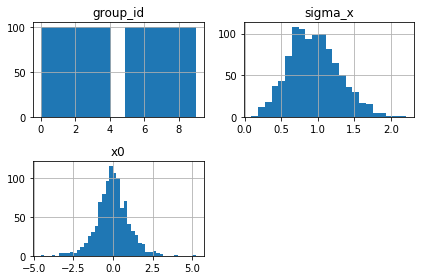

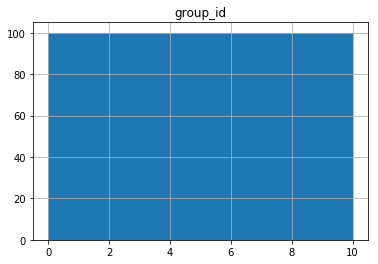

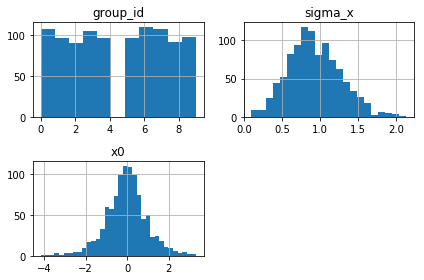

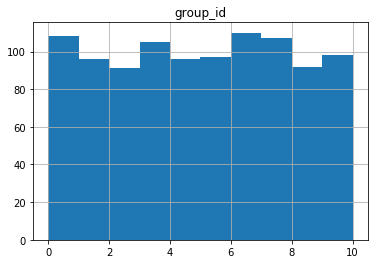

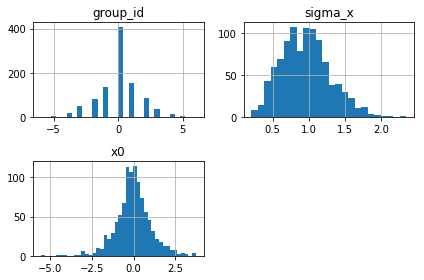

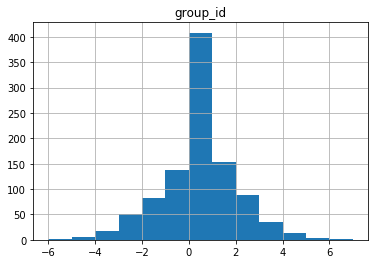

In [4]:
for grouping in ("uniform", "random", "normal"):
    data = generate_data(num_localizations=1000, df=4, grouping=grouping, groupsize=100, coords="x")
    data.hist(bins="auto")
    plt.tight_layout()
    data[["group_id"]].hist(bins=np.arange(data.group_id.min(), data.group_id.max()+2))
    

# Estimating the variance of the groups

First we need a weighted mean function

In [5]:
def weighted_mean(df):
    coords, sigmas = get_coords_sigmas(df)
    """Weighted mean as defined here https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Statistical_properties"""
    if len(df) == 1:
        return df[coords]
    weights = 1 / df[sigmas].values ** 2
    new_coords = (df[coords].values * weights).sum(0, keepdims=True) / weights.sum(0)
    return pd.DataFrame(new_coords, columns=coords)

In [6]:
weighted_mean(data).head()

,x0
0,-0.0199


## 1. My original method

https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_variance

Calculate new grouped sigma as basically the weighted standard deviation of the points added in quadrature to the standard deviation of the standard deviation of all points

$$
\sqrt{\frac{\sum w_i (x_i - \mu^*)^2}{\sum w_i} + \frac{1}{\sum w_i}} \\
\sqrt{\frac{\sum w_i x_i^2}{\sum w_i} - \mu^{*2} + \frac{1}{\sum w_i}} \\
\sqrt{\frac{\sum w_i x_i^2 + 1}{\sum w_i} - \mu^{*2}} \\
w_i = \frac{1}{\sigma_i^2}
$$

However, this is **wrong** as I can demonstrate with a bootstrapping method

In [7]:
def weighted_std1(df):
    coords, sigmas = get_coords_sigmas(df)
    """PeakSelector's Method"""
    if len(df) == 1:
        return df[sigmas]
    weights = 1 / df[sigmas].values ** 2
    V1 = weights.sum(0, keepdims=True)
    N = len(weights)
    mu = weighted_mean(df)[coords].values
    xi = df[coords].values
    var = (weights * (xi - mu) ** 2).sum(0, keepdims=True) / V1 + 1/V1
    return pd.DataFrame(np.sqrt(var), columns=sigmas)

In [8]:
weighted_std1(data)

,sigma_x
0,0.754774


## 2. PeakSelector Method

Basically boils down to weighted standard deviation of the group (where weights are # of photons) plus a term with the original spread of the frame localizations.

$$
\sigma_x^{gr} = \sqrt{
\frac{\sum_{i=0}^{n_{peaks}-1}(x_i - \bar{x})^2 Nphot_i}{n_{peaks} \sum_{i=0}^{n_{peaks}-1} Nphot_i} +
\frac{\sum_{i=0}^{n_{peaks}-1}\sigma_{x_i}^2 Nphot_i}{n_{peaks} \sum_{i=0}^{n_{peaks}-1} Nphot_i}
}
$$

$$
\sigma_x^{gr} = \sqrt{
\frac{\sum_{i=0}^{n_{peaks}-1}Nphot_i\left((x_i - \bar{x})^2 + \sigma_{x_i}^2\right)}{n_{peaks} \sum_{i=0}^{n_{peaks}-1} Nphot_i}
}
$$

Considering that # of photons is directly proportional to the variance in any direction, this can be rewritten as

$$
\sigma_x^{gr} = \sqrt{\frac{\sum w_i (x_i - \mu^*)^2}{N\sum w_i} + \frac{1}{\sum w_i}}
$$

where $w_i = 1 / \sigma_i^2$

In [9]:
def weighted_std_PS(df):
    coords, sigmas = get_coords_sigmas(df)
    """PeakSelector's Method"""
    if len(df) == 1:
        return df[sigmas]
    weights = 1 / df[sigmas].values ** 2
    V1 = weights.sum(0, keepdims=True)
    N = len(weights)
    mu = weighted_mean(df)[coords].values
    xi = df[coords].values
    var = (weights * (xi - mu) ** 2).sum(0, keepdims=True) / V1 / N + 1/V1
    return pd.DataFrame(np.sqrt(var), columns=sigmas)

In [10]:
weighted_std_PS(data)

,sigma_x
0,0.033782


# 3. Wikipedia

https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_variance
    
Note that this is the estimated sample variance, **not** the variance of the mean

In [11]:
def weighted_std_wiki(df):
    """https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_variance
    
    Note that this is the estimated sample variance, **not** the variance of the mean"""
    coords, sigmas = get_coords_sigmas(df)
    if len(df) == 1:
        return df[sigmas]
    weights = 1 / df[sigmas].values ** 2
    V1 = weights.sum(0, keepdims=True)
    V2 = (weights ** 2).sum(0, keepdims=True)
    mu = weighted_mean(df)[coords].values
    xi = df[coords].values
    denominator = V1 - V2 / V1
    var = (weights * (xi - mu) ** 2).sum(0, keepdims=True) / denominator
    return pd.DataFrame(np.sqrt(var), columns=sigmas)

In [12]:
weighted_std_wiki(data)

,sigma_x
0,0.755223


# 4. Wikipedia / Wes' Version

In [13]:
def weighted_std_wes(df):
    """Wes' version"""
    coords, sigmas = get_coords_sigmas(df)
    if len(df) == 1:
        return df[sigmas]
    wi = 1 / df[sigmas]**2
    var = 1 / (wi.sum(0))
    return pd.DataFrame(np.sqrt(var)).T

In [14]:
weighted_std_wes(data)

,sigma_x
0,0.023918


# 5. A new method
The equation given in Gatz, Donald F., and Luther Smith. “The Standard Error of a Weighted Mean Concentration—I. Bootstrapping vs Other Methods.” Atmospheric Environment 29, no. 11 (June 1, 1995): 1185–93. https://doi.org/10.1016/1352-2310(94)00210-C. on page 1186 is

$$
(SEM_w)^2 = \frac{n}{(n-1)\left(\sum P_i\right)^2}  \left[\sum (P_i X_i - \bar{P} \bar{X}_w)^2 - 
2 \bar{X}_w \sum (P_i - \bar{P})(P_i X_i - \bar{P}\bar{X}_w)
+ \bar{X}_w^2 \sum (P_i - \bar{P})^2 \right]
$$

It is never stated but seems safe to assume that $\bar{P} = \sum P_i$. We can write this in more usual notation where $\mu^* = \sum w_i x_i / \bar{w}$ where $\bar{w} = \sum w_i$ and $w_i$ are the weights of the measurement and $x_i$ are the measurements. Using this notation we have:

$$
(\text{SEM}_w)^2 = \frac{n}{(n-1)\bar{w}^2}  \left[\sum (w_i x_i - \bar{w} \mu^*)^2 - 
2 \mu^* \sum (w_i - \bar{w})(w_i x_i - \bar{w}\mu^*)
+ \mu^{*2} \sum (w_i - \bar{w})^2 \right]
$$

It can be shown that this reduces to:
$$
(SEM_w)^2 = \frac{n}{(n-1)\bar{w}^2}  \sum w_i^2(x_i - \mu^*)^2
$$

Which is similar to the weighted sample variance

$$
s^2 = \frac{\sum w_i (x_i - \mu^*)^2}{V_1 - (V_2 / V_1)}
$$

Where $V_1 = \sum w_i = \bar{w}$ and $V_2 = \sum w_i^2$

For computational purposes we can expand the equation to be

$$
(SEM_w)^2 = \frac{n}{(n-1)\bar{w}^2} \left( \sum w_i^2 x_i^2 - 2 \mu^* \sum w_i^2 x_i + \mu^{*2} \sum w_i^2 \right)
$$

In [15]:
# There is no generally accepted formula for the standard error of the weighted mean
# However this paper https://www.cs.tufts.edu/~nr/cs257/archive/donald-gatz/weighted-standard-error.pdf
# tests a few proposed formulas, this is the one they claim works the best which we'll
# test in a boot strap method

def weighted_std2(df):
    """https://www.cs.tufts.edu/~nr/cs257/archive/donald-gatz/weighted-standard-error.pdf"""
    coords, sigmas = get_coords_sigmas(df)
    if len(df) == 1:
        return df[sigmas]
    wi = 1 / df[sigmas].values ** 2
    V1 = wi.sum(0, keepdims=True)
    mu = weighted_mean(df)[coords].values
    xi = df[coords].values
    n = len(df)
    A = n / ((n-1) * V1 ** 2)
    a = (wi - V1)
    b = (wi * xi - V1 * mu)
    B = (b ** 2).sum(0, keepdims=True)
    C = 2 * mu * (a * b).sum(0, keepdims=True)
    D = (mu ** 2) * (a ** 2).sum(0, keepdims=True)
    s = A * (B - C + D)
    return pd.DataFrame(np.sqrt(s), columns=sigmas)

In [16]:
weighted_std2(data)

,sigma_x
0,0.025874


In [17]:
def bootstrap(mu, samples, trials=100, with_replacement=True):
    if with_replacement:
        # need to sample groupsizes too!
        # this will convert scalar into len 1 vector and leave vectors untouched
        samples = np.asarray(samples).reshape(-1)
        samples = choice(samples, size=trials)
        to_return = pd.concat([mu.sample(s, replace=True).std() for s in samples], axis=1, ignore_index=True).T
    else:
        mu_gb = mu.groupby(np.arange(len(mu)) // samples)
        to_return = mu_gb.std()
        
    to_return.columns = ["sigma_" + c[0] for c in to_return.columns]
    
    return to_return

In [18]:
def plot_compare(a, s):
    n = len(a.columns)
    fig, axs = plt.subplots(2, n, sharex=True, sharey=True, squeeze=False)
    for axs_h, d in zip(axs[::-1], (s, a)):
        for ax, key in zip(axs_h, a.columns):
            d[key].hist(bins="auto", ax=ax, density=True)
            
    for ax, key in zip(axs_h, a.columns):
        ax.set_title("$\\{}$".format(key))
        
    axs[0,0].set_ylabel("Actual PDF")
    axs[1,0].set_ylabel("Aggregated PDF")

In [19]:
import seaborn as sns
sns.set(context="paper")

In [20]:
colors = ("#1cfeba", "#9d8df1", "#ff8360", "#e8e288")
def plotter(groupsizes, dfs, hist=True, groupsize=10, num_groups=10, distribution="normal", grouping="uniform"):
    """Make a nice plot"""
    
    kwargs = dict(
        coords="x",
        distribution=distribution,
        grouping=grouping
    )
    
    if isinstance(groupsizes, list):
        myvars = groupsizes
        # make generator
        kwargs.update(df=dfs)
        datas = (generate_data(**kwargs, groupsize=groupsize, num_localizations=groupsize*num_groups) for groupsize in myvars)
        title_str = "Group Size = {}"
    else:
        myvars = dfs
        # make generator
        kwargs.update(num_localizations=groupsizes*num_groups, groupsize=groupsizes)
        datas = (generate_data(**kwargs, df=df) for df in myvars)
        title_str = "$\\chi^2$ DoF = {}"
        
    
    fig, axs_sup = plt.subplots(4, len(myvars), figsize=(10 * len(myvars) / 4, 10), sharex="col")
    
    methods = ("Bootstrap / Ground Truth", "Our Method", "Method 1", "Method 2")
    funcs = (weighted_std2, weighted_std_PS, weighted_std_wes)
    
    if hist:
        def subplot(data, color, ax):
            data.sigma_x.hist(ax=ax, bins="auto", density=True, histtype="stepfilled", linewidth=2, edgecolor="k", color=color)
    else:
        def subplot(data, color, ax):
            sns.kdeplot(data.sigma_x.values, shade=True, facecolor=color, color="k", alpha=1, ax=ax, linewidth=2)
            
    # iterate through variable and plot
    for axs, data in zip(axs_sup.T, datas):
        gb = data.groupby("group_id")
        # calculate weighted mean of groups
        mu = gb.apply(weighted_mean)
        actual = bootstrap(mu, gb.size(), with_replacement=True, trials=len(gb))
        subplot(actual, colors[0], axs[0])

        for ax, func, c in zip(axs[1:], funcs, colors[1:]):
            s = gb.apply(func).reset_index(drop=True)
            if len(np.unique(s)) == 1:
                ax.axvline(s.values[0], linewidth=2, color="k")
            else:
                subplot(s, c, ax)

            ax.set_title("")

    for ax in axs_sup.ravel():
        ax.yaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_minor_locator(plt.NullLocator())

    for ax, var in zip(axs_sup[0], myvars):
        if var is None:
            var = "$\\infty$"
        ax.set_title(title_str.format(var), fontsize="x-large")

    for ax in axs_sup[-1]:
        ax.set_xlabel("Group Precision (a.u.)", fontsize="x-large")

    for ax, t in zip(axs_sup[:, 0], methods):
        ax.set_ylabel(t, fontsize="x-large")

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    return fig, axs_sup

In [ ]:
plotter([10,100], None, hist=False, grouping="random", num_groups=10)
plotter([10,100], None, hist=True, grouping="random", num_groups=10)

In [ ]:
[5**i for i in range(1, 5)]

In [ ]:
for hist in (True, False):
    if hist:
        prefix = "Histogram "
    else:
        prefix = "KDE "
    for grouping in ("uniform", "random"):
        for distribution in ("uniform", "normal"):
            basetitle = "Grouping Simulations " + prefix + "{} Point Distribution, {} Grouping".format(distribution.capitalize(), grouping.capitalize())

            print(basetitle)
            # median group size is 5, mean is 10
            fig, axs = plotter([5**i for i in range(1, 5)], 16, hist=hist, grouping=grouping, num_groups=1000, distribution=distribution)
            fig.savefig(basetitle + " Groupsizes.pdf")
            plt.show()
            # calculated DoF is about 16-17 for real data
            fig, axs = plotter(5, [4**i for i in range(1, 5)], hist=hist, grouping=grouping, num_groups=1000, distribution=distribution)
            plt.show()
            fig.savefig(basetitle + " Chi2 DoFs.pdf")

In [ ]:
fig, axs = plotter(10, [4, 16, 4**3, None], hist=hist, grouping=grouping, num_groups=100, distribution=distribution)


In [ ]:
fig, axs = plotter(5, [4**i for i in range(1, 5)], hist=hist, grouping="uniform", num_groups=100, distribution="normal")


In [ ]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
for (i, ax), c in zip(enumerate(axs), colors):
    k = 4**(i + 1)
    m = chi2.mean(k)
    x = np.linspace(0, 2 * m, 128)
    ax.fill_between(x / m, chi2.pdf(x, k) * m, color=c)
    ax.plot(x / m, chi2.pdf(x, k) * m, color="k")

In [ ]:
for df in [4**i for i in range(1, 5)]:
    data = generate_data(num_localizations=100*10, groupsize=10, grouping="uniform", distribution="normal", df=df, coords="x")
    (data[["x0"]]).plot.kde()
    print(data.describe())

In [21]:
def bootstrap2(frame, samples, trials=100):
    # need to sample groupsizes too!
    # this will convert scalar into len 1 vector and leave vectors untouched
    samples = np.asarray(samples).reshape(-1)
    samples = choice(samples, size=trials)
    to_return = pd.concat([frame.sample(s, replace=True).agg({"x0":"var", "sigma_x":"mean"}) for s in samples], axis=1, ignore_index=True).T
    
    return to_return

In [22]:
colors = ("#1cfeba", "#9d8df1", "#ff8360", "#e8e288")
def plotter2(groupsizes, dfs, hist=True, groupsize=10, num_groups=10, distribution="normal", grouping="uniform"):
    """Make a nice plot"""
    
    kwargs = dict(
        coords="x",
        distribution=distribution,
        grouping=grouping
    )
    

    # make generator
    # groupsize is slow axis, df is fast axis
    kwds = (dict(groupsize=groupsize, num_localizations=groupsize*num_groups, df=df) for groupsize in groupsizes for df in dfs)
    
    fig, axs_sup = plt.subplots(len(groupsizes), len(dfs), figsize=(10 * len(dfs) / len(groupsizes), 10), squeeze=False)
    
    methods = ("Our Method", "Method 1", "Method 2")
    funcs = (weighted_std2, weighted_std_PS, weighted_std_wes)
    
    if hist:
        def subplot(data, color, ax, label):
            data.plot.scatter("x0", "sigma_x", ax=ax, color=color, label=label)
    else:
        def subplot(data, color, ax, label):
            sns.kdeplot(data.x0, data.sigma_x, color=color, alpha=1, ax=ax, label=label)
            
    # iterate through variable and plot
    for ax, kwd in zip(axs_sup.ravel(), kwds,):
        kwargs.update(kwd)
        data = generate_data(**kwargs)
        gb = data.groupby("group_id")
        # calculate weighted mean of groups
        mu = gb.apply(weighted_mean).reset_index(drop=True)

        for func, c, label in zip(funcs, colors, methods):
            s = gb.apply(func).reset_index(drop=True)
            actual = bootstrap(pd.concat((mu, s**2), axis=1), gb.size(), trials=len(gb))
            subplot(actual, c, ax, label)
        ax.set_title("$\\chi^2$ DoF = {df}".format(**kwd), fontsize="x-large")
        ax.set_ylabel("Group Size = {groupsize}".format(**kwd), fontsize="x-large")
        ax.set_aspect(1)
        x = [actual.x0.min(), actual.x0.max()]
        ax.plot(x, x)

    for ax in axs_sup[1:].ravel():
        ax.set_title("")
        
    for ax in axs_sup[:, 1:].ravel():
        ax.set_ylabel("")

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    return fig, axs_sup

In [ ]:
plotter([5**i for i in range(1,3)], [100**i for i in range(1,3)], hist=False, num_groups=100)

In [23]:
from scipy.stats import ks_2samp, wasserstein_distance

In [24]:
colors = ("#1cfeba", "#9d8df1", "#ff8360", "#e8e288")
def plotter3(groupsizes, dfs, hist=True, groupsize=10, num_groups=10, distribution="normal", grouping="uniform", cumulative=False):
    """Make a nice plot"""
    colors = ("#1cfeba", "#9d8df1", "#ff8360", "#e8e288")
    sharey = False
    kwargs = dict(
        coords="x",
        distribution=distribution,
        grouping=grouping
    )
    
    if cumulative:
        colors =sns.color_palette("Set2", 4)
        sharey = True

    # make generator
    # groupsize is slow axis, df is fast axis
    kwds = (dict(groupsize=groupsize, num_localizations=groupsize*num_groups, df=df)for df in dfs for groupsize in groupsizes)
    
    fig, axs_sup = plt.subplots(len(groupsizes), len(dfs), figsize=(5 * len(groupsizes), 5 * len(dfs)), sharey=sharey, squeeze=False)
    
    methods = ("Method 0", "Method 1", "Method 2")
    funcs = (weighted_std2, weighted_std_PS, weighted_std_wes)
    
    if cumulative:
        colors =sns.color_palette("Set2", 4)
    
    if hist:
        if cumulative:
            def subplot(data, color, ax, label):
                x = data.sigma_x.sort_values()
                y = (np.arange(len(x)) + 1) / len(x)
                ax.plot(x, y, color=color, linewidth=3, label=label)
        else:
            def subplot(data, color, ax, label):
                data.sigma_x.hist(ax=ax, bins="auto", density=True, histtype="stepfilled", linewidth=2, edgecolor="k", color=color, label=label, alpha=0.5)
    else:
        if cumulative:
            def subplot(data, color, ax, label):
                sns.kdeplot(data.sigma_x.values, color=color, ax=ax, linewidth=2, label=label, cumulative=cumulative)
        else:
            def subplot(data, color, ax, label):
                sns.kdeplot(data.sigma_x.values, shade=True, facecolor=color, color="k", ax=ax, linewidth=2, label=label, alpha=0.5)
            
    # iterate through variable and plot
    for i, (ax, kwd) in enumerate(zip(axs_sup.ravel(), kwds)):
        kwargs.update(kwd)
        data = generate_data(**kwargs)
        gb = data.groupby("group_id")
        # calculate weighted mean of groups
        mu = gb.apply(weighted_mean).reset_index(drop=True)
        actual = bootstrap(mu, gb.size(), trials=len(gb), with_replacement=True)
        
        if i == 0:
            l = "Bootstrap"
        else:
            l = "_none"
        subplot(actual, colors[0], ax, l)
        
        for func, c, label in zip(funcs, colors[1:], methods):
            s = gb.apply(func).reset_index(drop=True)
            if i != 0:
                label = "$"
            else:
                label = label + ", $D = "
            subplot(s, c, ax, label + "{:.2f}$".format(ks_2samp(actual.sigma_x, s.sigma_x).statistic))
        
        ax.set_ylabel("$\\chi^2$ DoF = {df}".format(**kwd), fontsize="x-large")
        ax.set_title("Group Size = {groupsize}".format(**kwd), fontsize="x-large")
        
        if hist or cumulative:
            ax.legend()
        else:
            ax.legend(ax.collections, ("Bootstrap",) + methods)

    for ax in axs_sup[1:].ravel():
        ax.set_title("")
        
    for ax in axs_sup[:, 1:].ravel():
        ax.set_ylabel("")
        
#     for ax in np.roll(axs_sup.ravel(), 3)[1:]:
#         ax.legend_.remove()
        
    for ax in axs_sup.ravel():
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    for ax in axs_sup[-1]:
        ax.set_xlabel("Group Precision (a.u.)", fontsize="x-large")

    fig.subplots_adjust(wspace=0.05, hspace=0.1)
    return fig, axs_sup

Grouping Simulations Histogram Normal Point Distribution, Uniform Grouping


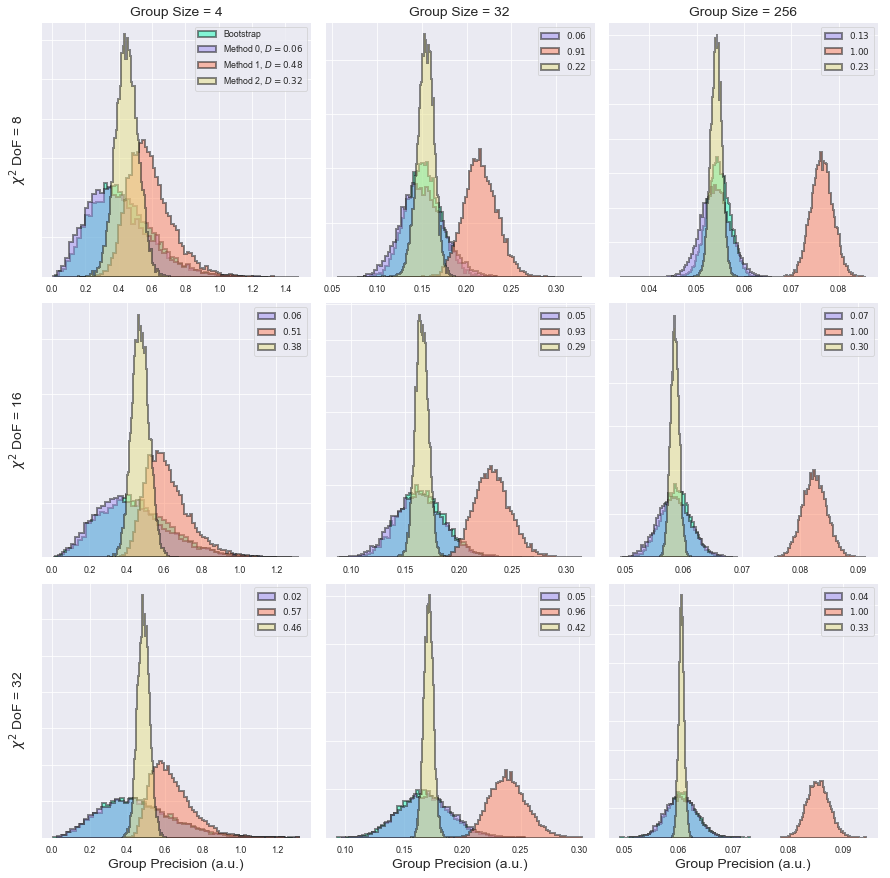

Grouping Simulations Histogram Normal Point Distribution, Uniform Grouping Cumulative


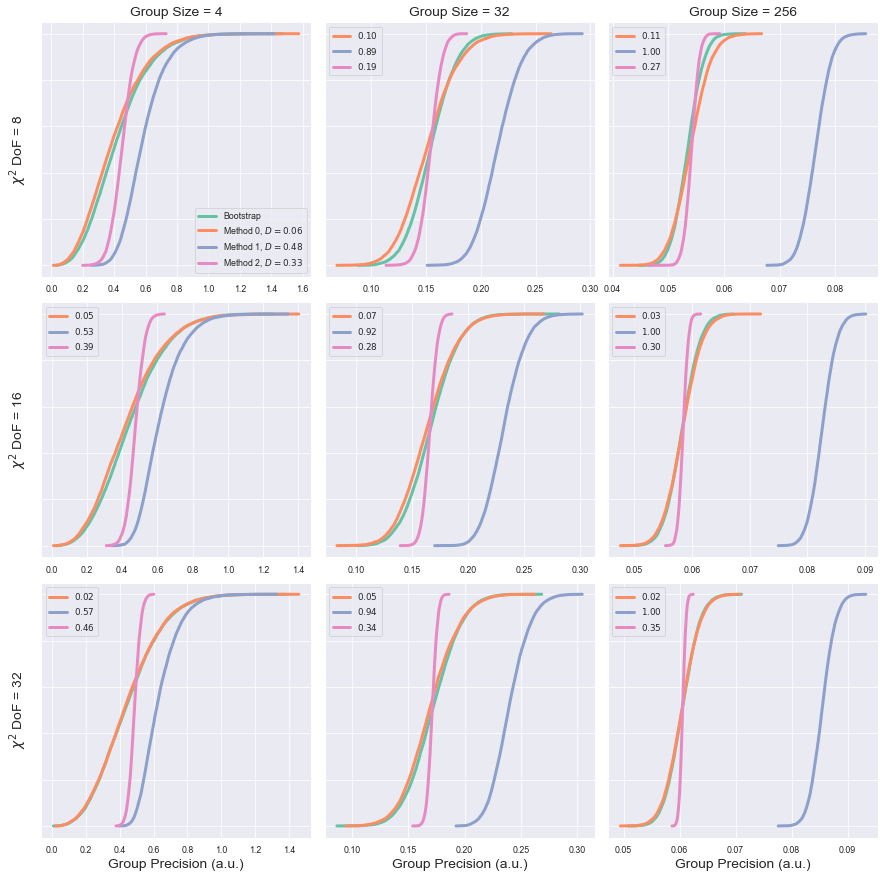

Grouping Simulations Histogram Uniform Point Distribution, Uniform Grouping


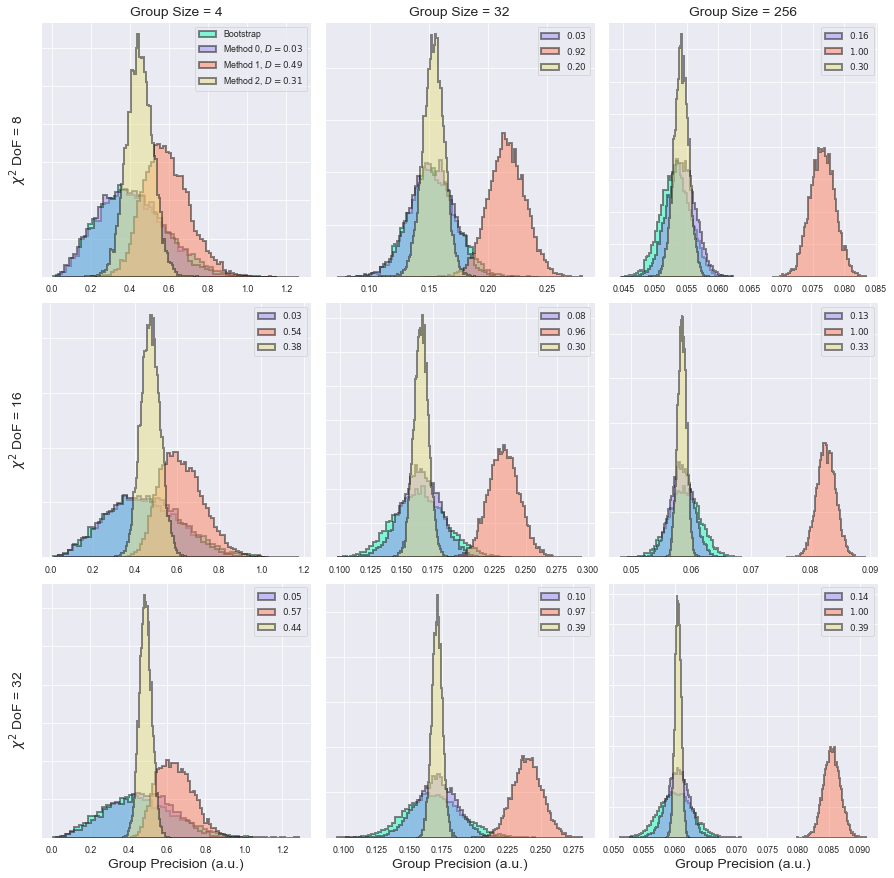

Grouping Simulations Histogram Uniform Point Distribution, Uniform Grouping Cumulative


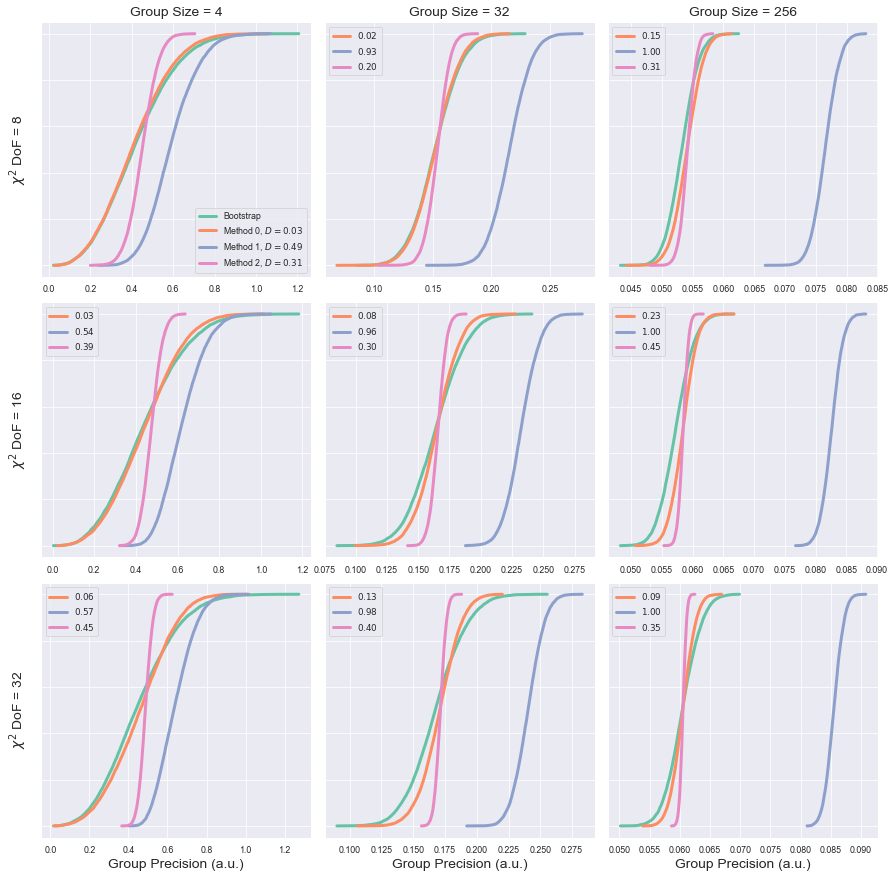

Grouping Simulations KDE Normal Point Distribution, Uniform Grouping


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


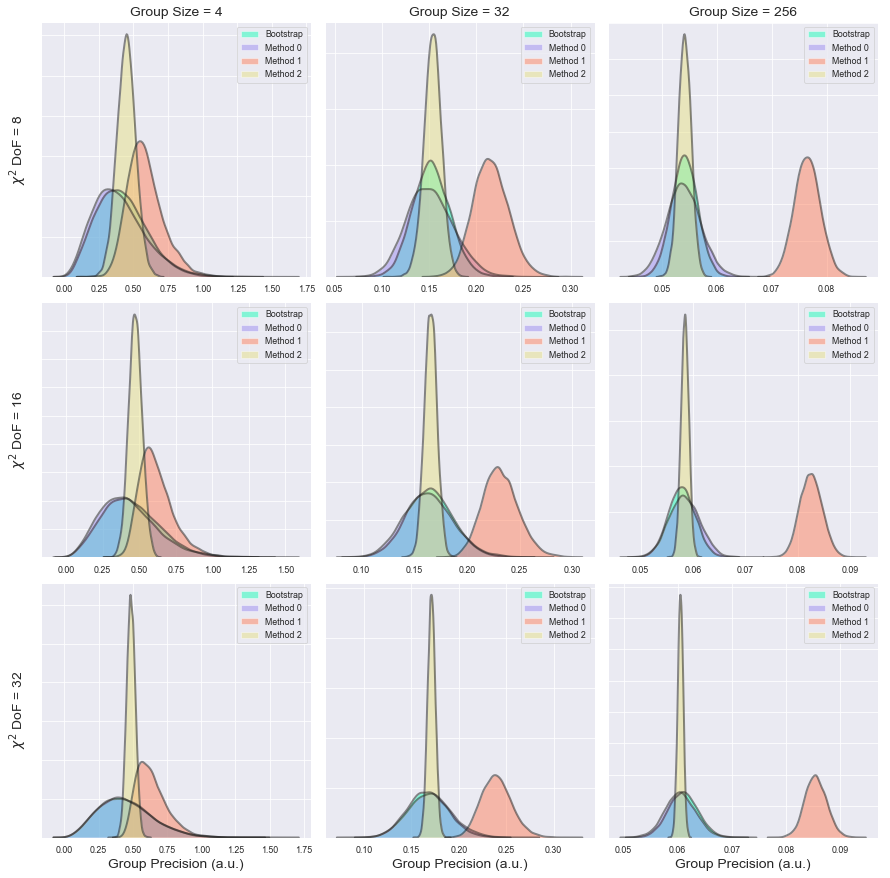

Grouping Simulations KDE Normal Point Distribution, Uniform Grouping Cumulative


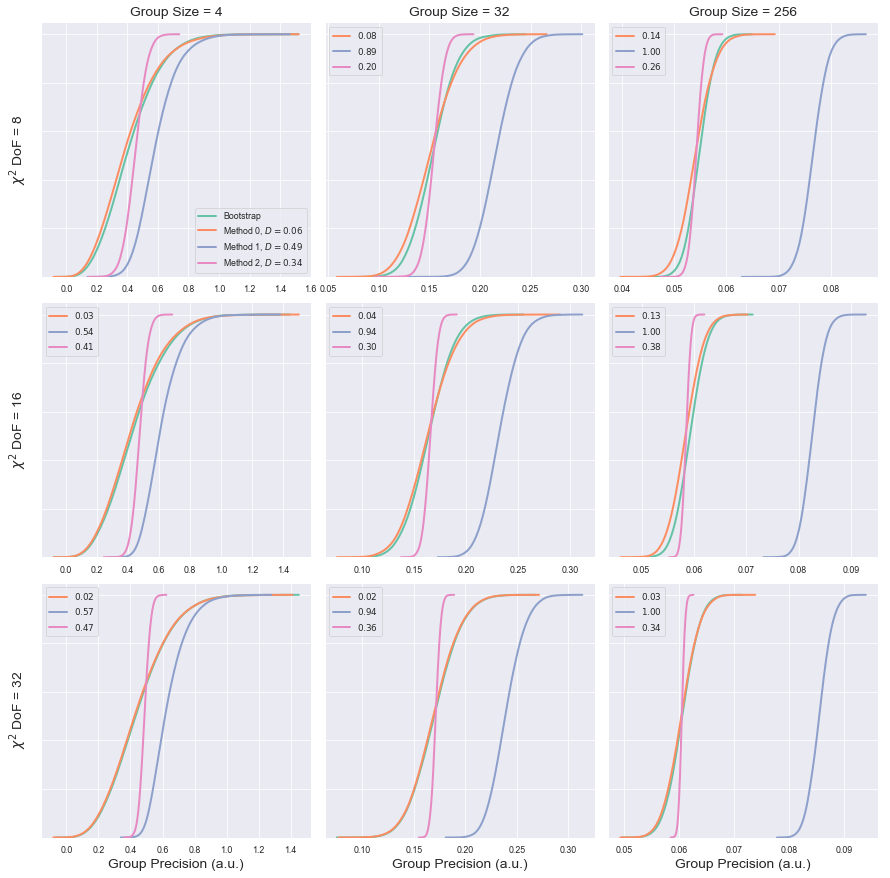

Grouping Simulations KDE Uniform Point Distribution, Uniform Grouping


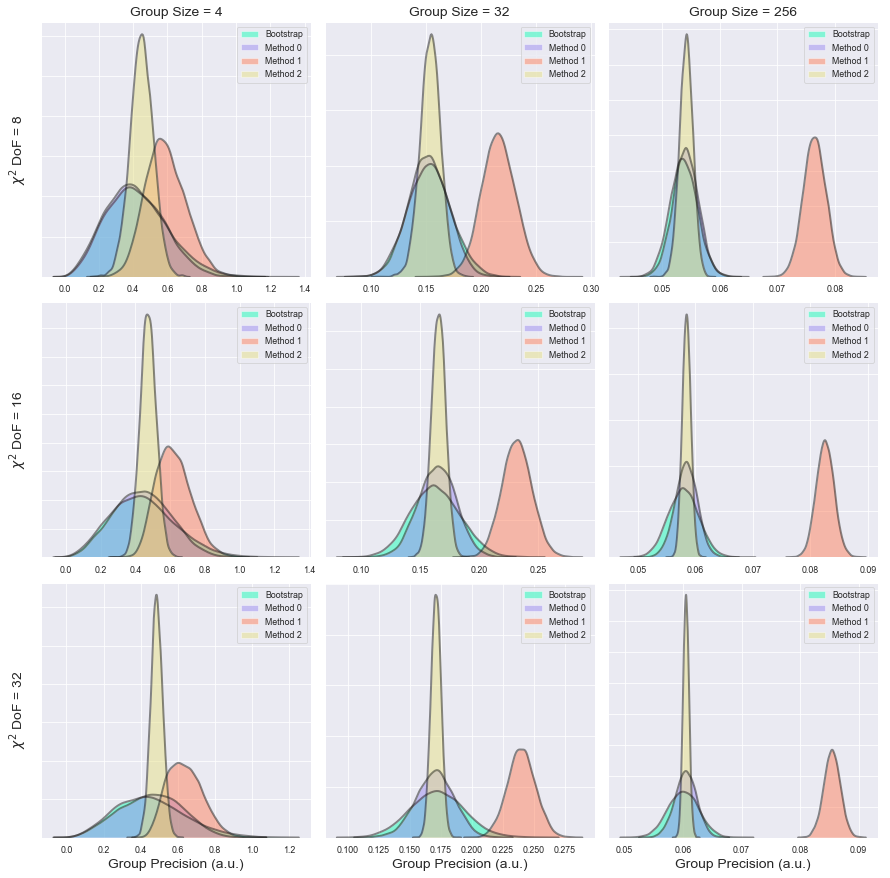

Grouping Simulations KDE Uniform Point Distribution, Uniform Grouping Cumulative


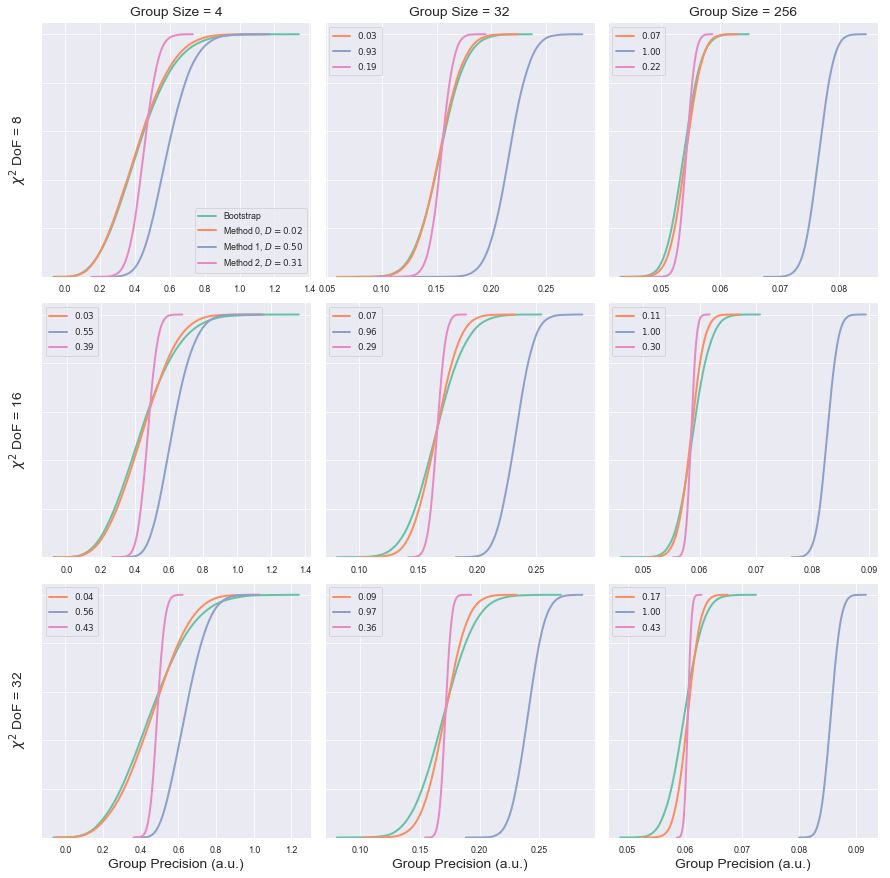

In [29]:
for hist in (True, False):
    if hist:
        prefix = "Histogram "
    else:
        prefix = "KDE "
    for grouping in ("uniform", ):
        for distribution in ("normal", "uniform"):
            basetitle = "Grouping Simulations " + prefix + "{} Point Distribution, {} Grouping".format(distribution.capitalize(), grouping.capitalize())
            for cumulative in (False, True):
                if cumulative:
                    basetitle = basetitle + " Cumulative"
                
                print(basetitle)
                # median group size is 5, mean is 10
                # calculated DoF is about 16-17 for real data
                fig, axs = plotter3([4 * 8**i for i in range(0, 3)], [8 * 2**i for i in range(0, 3)], hist=hist, grouping=grouping, num_groups=10000, distribution=distribution, cumulative=cumulative)
                plt.show()
                fig.savefig(basetitle + ".pdf")

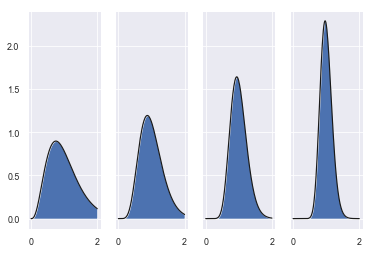

In [26]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
for (i, ax), c in zip(enumerate(axs), colors):
    k = 8 * 2**i
    m = chi2.mean(k)
    x = np.linspace(0, 2 * m, 128)
    ax.fill_between(x / m, chi2.pdf(x, k) * m)
    ax.plot(x / m, chi2.pdf(x, k) * m, color="k")

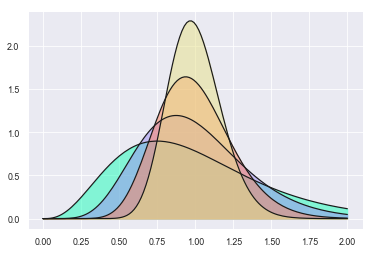

In [27]:
fig, ax = plt.subplots()
for i, c in enumerate(colors):
    k = 8 * 2**i
    m = chi2.mean(k)
    x = np.linspace(0, 2 * m, 128)
    ax.fill_between(x / m, chi2.pdf(x, k) * m, color=c, alpha=0.5)
    ax.plot(x / m, chi2.pdf(x, k) * m, color="k")

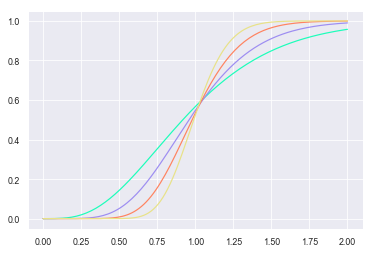

In [28]:
fig, ax = plt.subplots()
for i, c in enumerate(colors):
    k = 8 * 2**i
    m = chi2.mean(k)
    x = np.linspace(0, 2 * m, 128)
    ax.plot(x / m, chi2.cdf(x, k), color=c)

In [27]:
def weighted_std_PS2(df):
    coords, sigmas = get_coords_sigmas(df)
    """PeakSelector's Method"""
    if len(df) == 1:
        return df[sigmas]
    weights = 1 / df[sigmas].values ** 2
    V1 = weights.sum(0, keepdims=True)
    N = len(weights)
    mu = weighted_mean(df)[coords].values
    xi = df[coords].values
    var = (weights * (xi - mu) ** 2).sum(0, keepdims=True) / V1 / N + 1/V1
    return pd.DataFrame(np.sqrt(var/2), columns=sigmas)

In [28]:
colors = ("#1cfeba", "#9d8df1", "#ff8360", "#e8e288")
def plotter4(groupsizes, dfs, hist=True, groupsize=10, num_groups=10, distribution="normal", grouping="uniform", cumulative=False):
    """Make a nice plot"""
    colors = ("#1cfeba", "#9d8df1", "#ff8360", "#e8e288")
    sharey = False
    kwargs = dict(
        coords="x",
        distribution=distribution,
        grouping=grouping
    )
    
    if cumulative:
        colors =sns.color_palette("Set2", 4)
        sharey = True

    # make generator
    # groupsize is slow axis, df is fast axis
    kwds = (dict(groupsize=groupsize, num_localizations=groupsize*num_groups, df=df)for df in dfs for groupsize in groupsizes)
    
    fig, axs_sup = plt.subplots(len(groupsizes), len(dfs), figsize=(5 * len(groupsizes), 5 * len(dfs)), sharey=sharey, squeeze=False)
    
    methods = ("Method 0", "Method 1", "Method 2")
    funcs = (weighted_std2, weighted_std_PS2, weighted_std_wes)
    
    if cumulative:
        colors =sns.color_palette("Set2", 4)
    
    if hist:
        if cumulative:
            def subplot(data, color, ax, label):
                x = data.sigma_x.sort_values()
                y = (np.arange(len(x)) + 1) / len(x)
                ax.plot(x, y, color=color, linewidth=3, label=label)
        else:
            def subplot(data, color, ax, label):
                data.sigma_x.hist(ax=ax, bins="auto", density=True, histtype="stepfilled", linewidth=2, edgecolor="k", color=color, label=label, alpha=0.5)
    else:
        if cumulative:
            def subplot(data, color, ax, label):
                sns.kdeplot(data.sigma_x.values, color=color, ax=ax, linewidth=2, label=label, cumulative=cumulative)
        else:
            def subplot(data, color, ax, label):
                sns.kdeplot(data.sigma_x.values, shade=True, facecolor=color, color="k", ax=ax, linewidth=2, label=label, alpha=0.5)
            
    # iterate through variable and plot
    for i, (ax, kwd) in enumerate(zip(axs_sup.ravel(), kwds)):
        kwargs.update(kwd)
        data = generate_data(**kwargs)
        gb = data.groupby("group_id")
        # calculate weighted mean of groups
        mu = gb.apply(weighted_mean).reset_index(drop=True)
        actual = bootstrap(mu, gb.size(), trials=len(gb), with_replacement=True)
        
        if i == 0:
            l = "Bootstrap"
        else:
            l = "_none"
        subplot(actual, colors[0], ax, l)
        
        for func, c, label in zip(funcs, colors[1:], methods):
            s = gb.apply(func).reset_index(drop=True)
            if i != 0:
                label = "$"
            else:
                label = label + ", $D = "
            subplot(s, c, ax, label + "{:.2f}$".format(ks_2samp(actual.sigma_x, s.sigma_x).statistic))
        
        ax.set_ylabel("$\\chi^2$ DoF = {df}".format(**kwd), fontsize="x-large")
        ax.set_title("Group Size = {groupsize}".format(**kwd), fontsize="x-large")
        
        if hist or cumulative:
            ax.legend()
        else:
            ax.legend(ax.collections, ("Bootstrap",) + methods)

    for ax in axs_sup[1:].ravel():
        ax.set_title("")
        
    for ax in axs_sup[:, 1:].ravel():
        ax.set_ylabel("")
        
#     for ax in np.roll(axs_sup.ravel(), 3)[1:]:
#         ax.legend_.remove()
        
    for ax in axs_sup.ravel():
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    for ax in axs_sup[-1]:
        ax.set_xlabel("Group Precision (a.u.)", fontsize="x-large")

    fig.subplots_adjust(wspace=0.05, hspace=0.1)
    return fig, axs_sup

Grouping Simulations Histogram Normal Point Distribution, Uniform Grouping


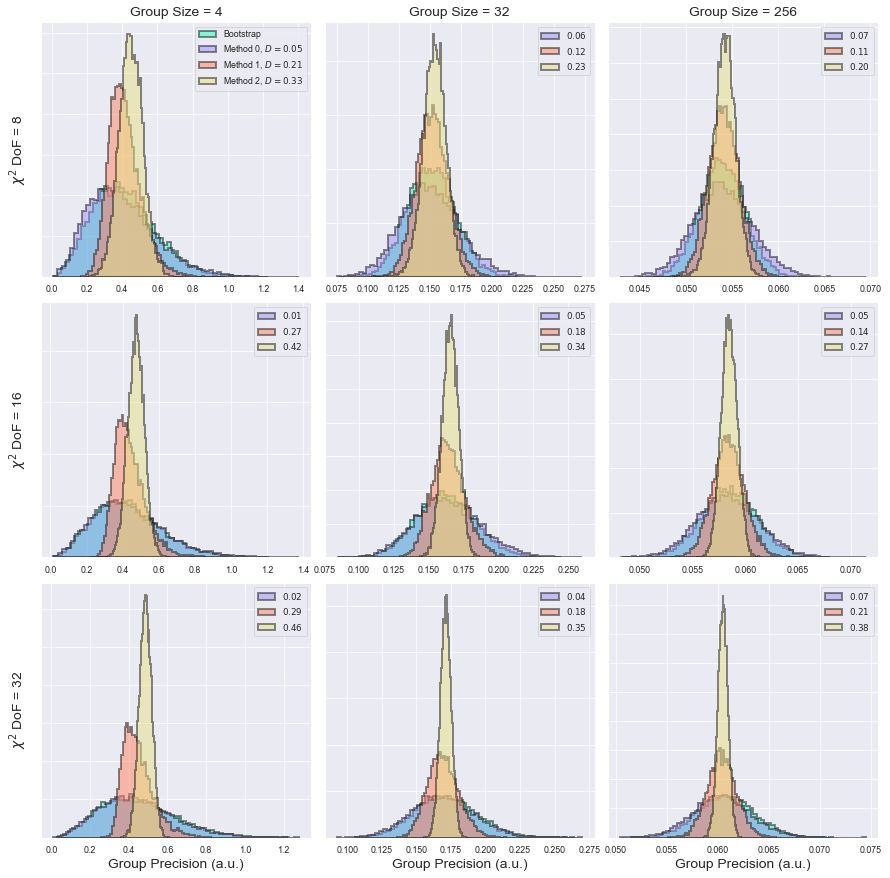

Grouping Simulations Histogram Normal Point Distribution, Uniform Grouping Cumulative


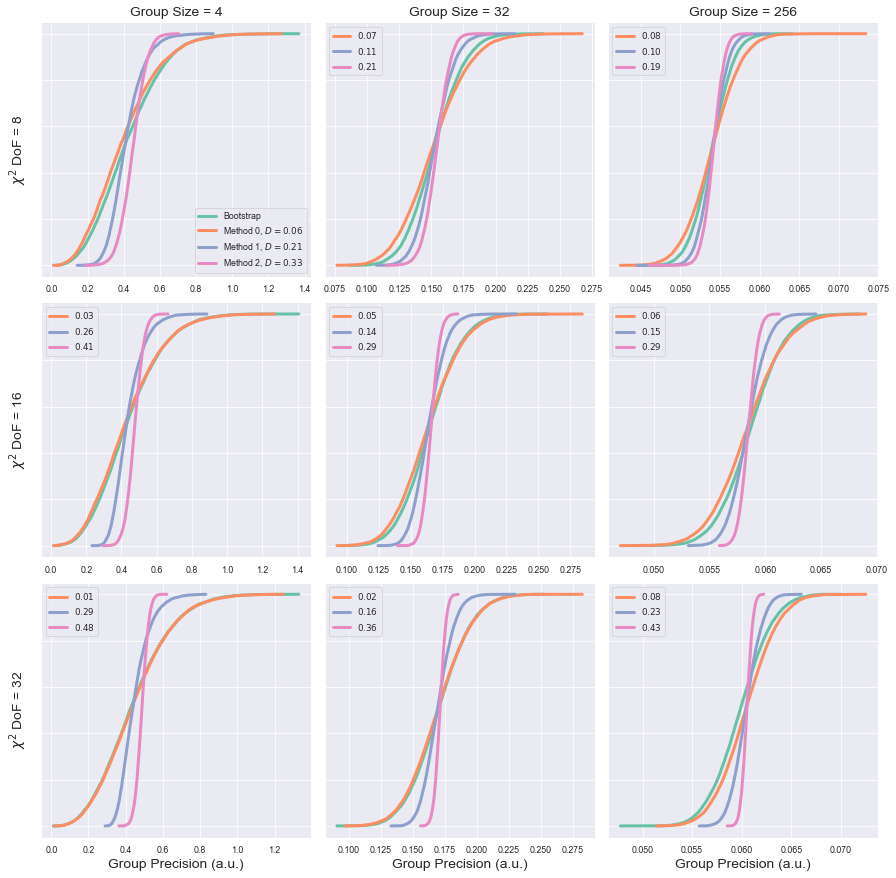

Grouping Simulations Histogram Uniform Point Distribution, Uniform Grouping


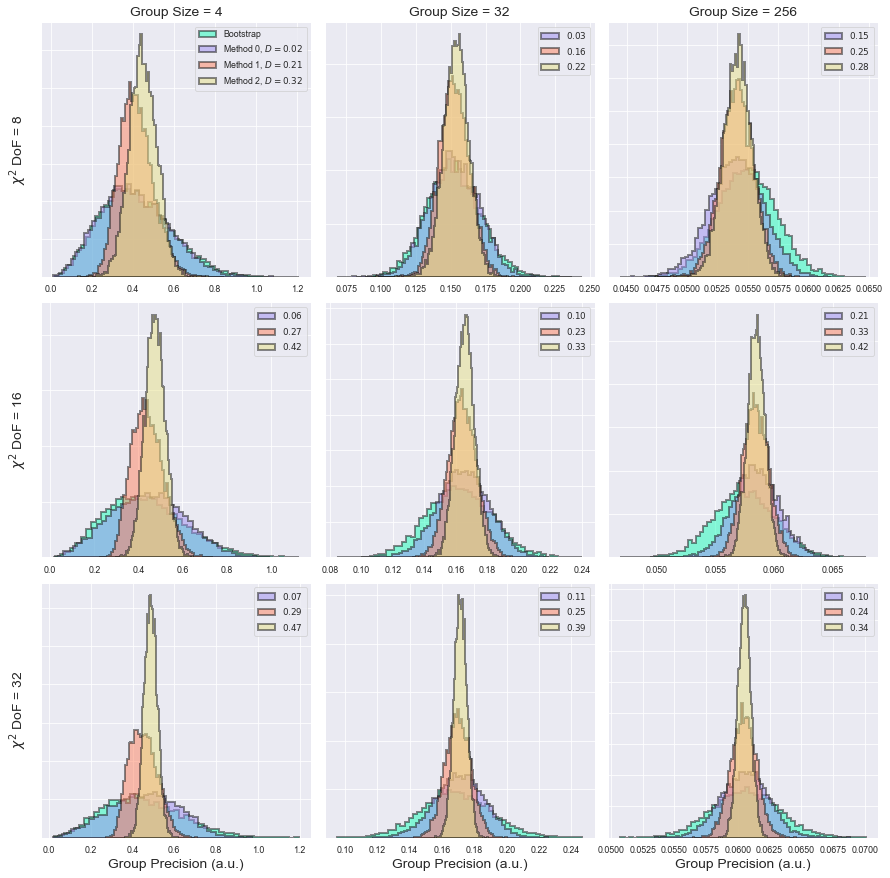

Grouping Simulations Histogram Uniform Point Distribution, Uniform Grouping Cumulative


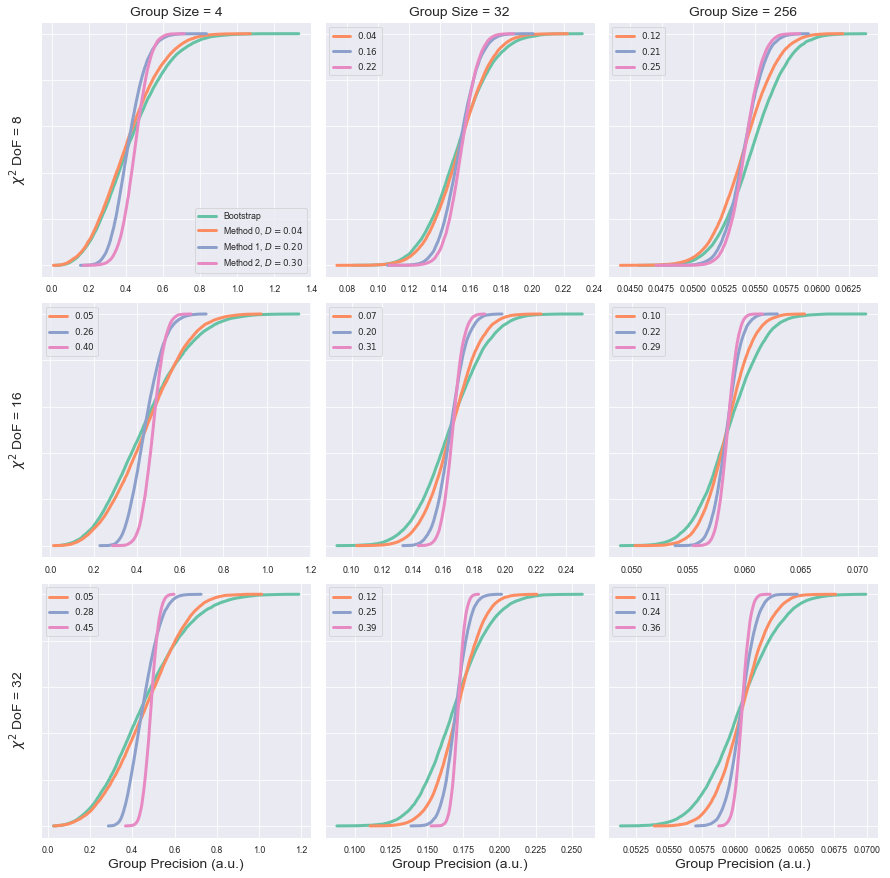

Grouping Simulations KDE Normal Point Distribution, Uniform Grouping


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


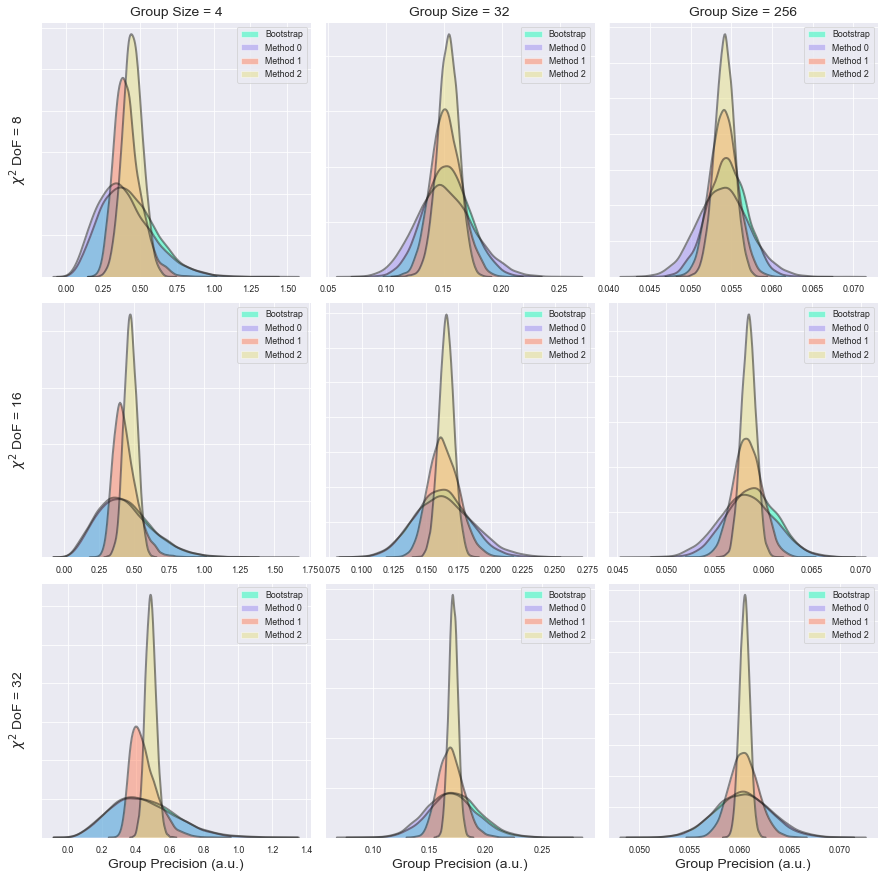

Grouping Simulations KDE Normal Point Distribution, Uniform Grouping Cumulative


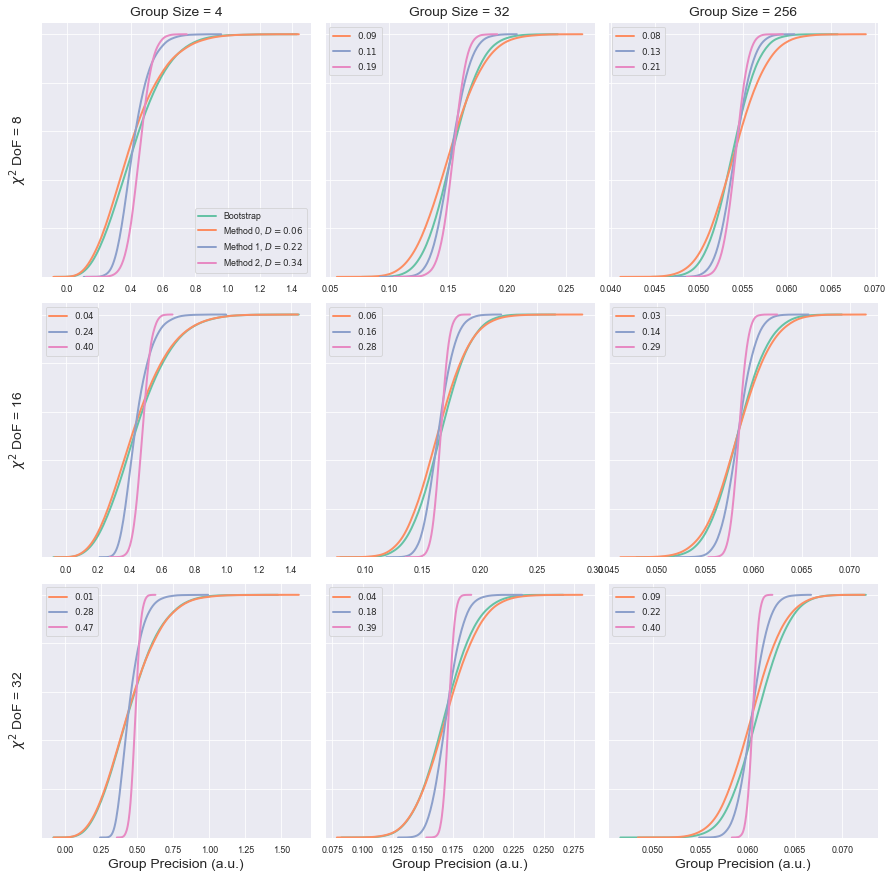

Grouping Simulations KDE Uniform Point Distribution, Uniform Grouping


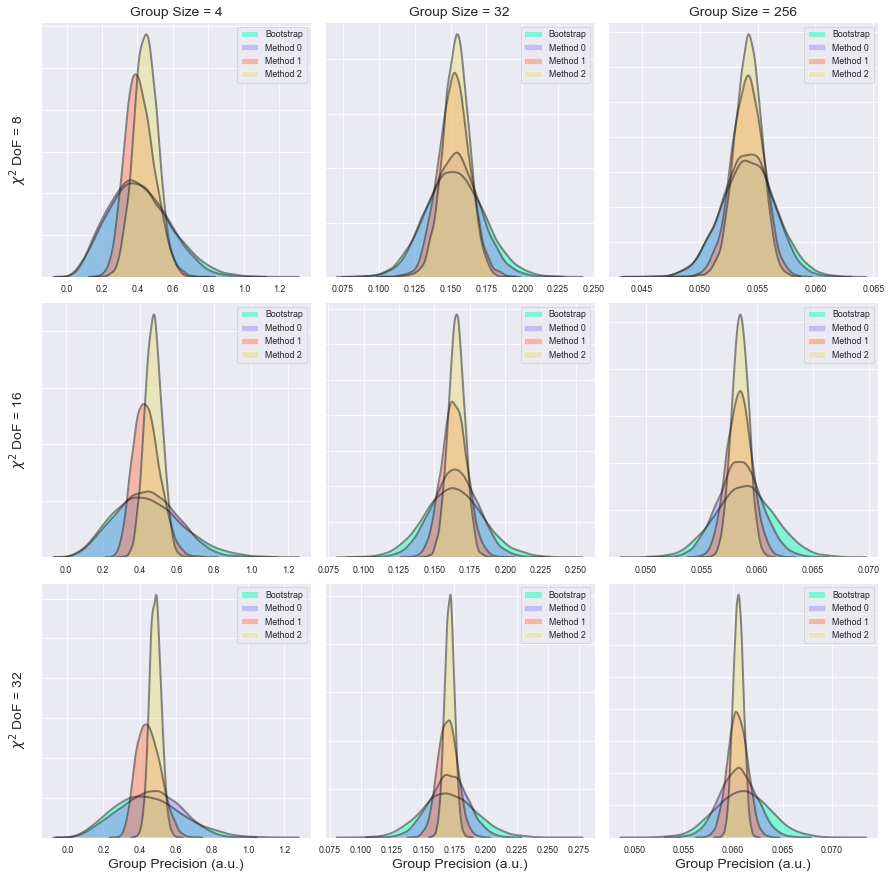

Grouping Simulations KDE Uniform Point Distribution, Uniform Grouping Cumulative


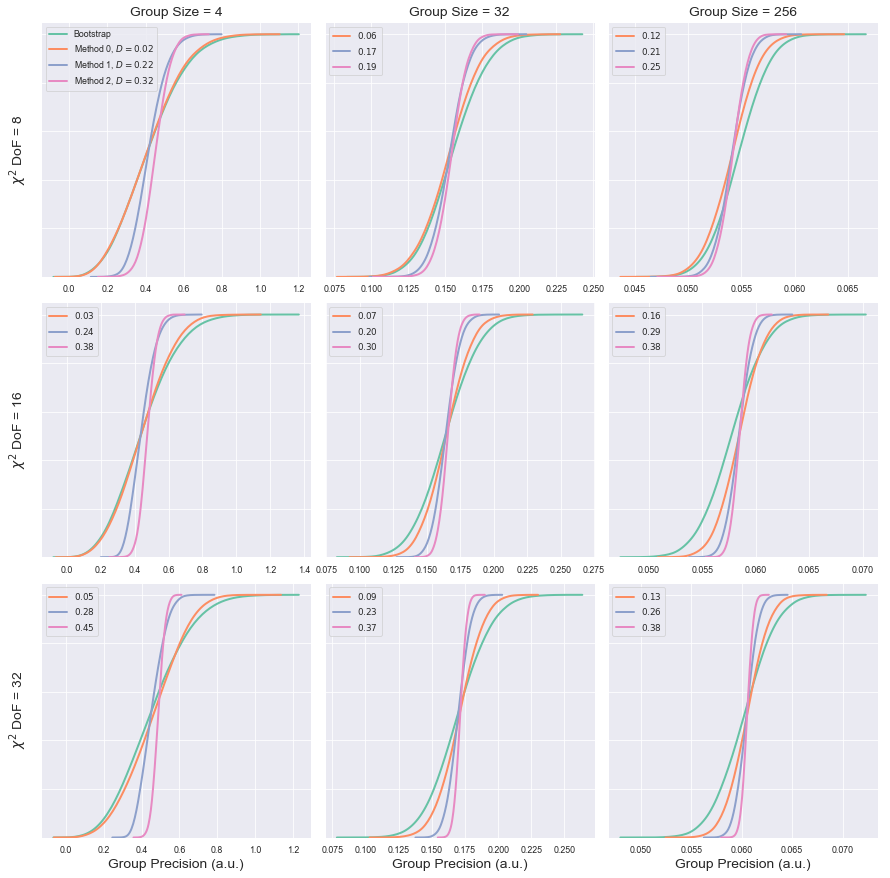

In [30]:
for hist in (True, False):
    if hist:
        prefix = "Histogram "
    else:
        prefix = "KDE "
    for grouping in ("uniform", ):
        for distribution in ("normal", "uniform"):
            basetitle = "Grouping Simulations " + prefix + "{} Point Distribution, {} Grouping".format(distribution.capitalize(), grouping.capitalize())
            for cumulative in (False, True):
                if cumulative:
                    basetitle = basetitle + " Cumulative"
                
                print(basetitle)
                # median group size is 5, mean is 10
                # calculated DoF is about 16-17 for real data
                fig, axs = plotter4([4 * 8**i for i in range(0, 3)], [8 * 2**i for i in range(0, 3)], hist=hist, grouping=grouping, num_groups=10000, distribution=distribution, cumulative=cumulative)
                plt.show()
                fig.savefig(basetitle + " B.pdf")